###  Outputs:



Tables
- Tables of coverage by 5 years
    - Country level, aggregated to region, super region, global

Figures
- Global, superregional trends in coverage
- Maps of coverage
- Ordered bar/map graph of vaccine differential
- Scatters of DPT1/DPT3 ratio over time

In [222]:
rm(list=ls())
model_root <-'/snfs2/HOME/pyliu/git/ubcov_central/modules/model'
setwd(model_root)
source('init.r')
source('register_data.r')

os <- .Platform$OS.type
if (os == "windows") {
  j <- "J:/"
  h <- "H:/"
} else {
  j <- "/home/j/"
  user <- Sys.info()[["user"]]
  h <- paste0("/snfs2/HOME/", user)
}
library(ggplot2)
library(feather, lib.loc="/snfs2/HOME/pyliu/R/x86_64-unknown-linux-gnu-library/3.1")
library(gridExtra, lib.loc="/share/local/R-3.1.2/lib64/R/library")
library(ggthemes, lib.loc="~/R/lib/3.3")
library(rje, lib.loc="~/R/lib/3.3")
library(extrafont, lib.loc="~/R/lib/3.3")

source("/home/j/WORK/01_covariates/02_inputs/hsa/code/init.r")
source(paste0(code_root, "/diagnostics/map/global_map.R"))

draws_root <- "/share/covariates/hsa/draws/exp"
temp_root <- paste0(j, '/temp/pyliu/scratch/thesis')

me.db <- fread(me_db)

[1] "Paths loaded"


## Functions

In [3]:
load.draws <- function(me) {
    return(read_feather(paste0('/home/j/temp/pyliu/scratch/thesis/draws/', me, '.feather')) %>% data.table)
}

In [4]:
load.pop <- function() {
    return(readRDS("/home/j/WORK/01_covariates/02_inputs/hsa/data/exp/reference/pop_cache.rds"))
}

In [5]:
aggregate.draws <- function(df, vars, by="super_region_name") {
  key <- c("year_id", by)
  agg <- df %>% copy
  ## Aggregate estimates to the parent_id [ sum(var * pop) /sum_pop ]
  agg <- agg[, sum_pop := sum(population), by=key]
  agg <- agg[, (vars) := lapply(.SD, function(x) x * agg[['population']]), .SDcols=vars]
  agg <- agg[, (vars) := lapply(.SD, sum), .SDcols=vars, by=key]
  ## De-duplicate so get one set of estimates
  agg <- unique(agg[, c(by, "year_id", "age_group_id", "sex_id", "sum_pop", vars), with=F])
  ## Divide by sum_pop
  agg <- agg[, (vars) := lapply(.SD, function(x) x/agg[['sum_pop']]), .SDcols=vars]
  agg <- agg[, sum_pop := NULL]
  ## Rename parent_id -> location_id
  return(agg)
}

In [6]:
collapse.draws <- function(me, level) {
## Load data
df <- load.draws(me)
pop <- load.pop() %>% data.table
df <- merge(df, pop[, .(location_id, year_id, population)], by=c("location_id", "year_id"), all.x=TRUE)
var.lvl <- paste0("level_", level)
locs <- get_location_hierarchy(149)[, c("location_id", var.lvl, "location_name"), with=F]
df <- merge(df, locs[, c("location_id", var.lvl), with=F], by='location_id', all.x=TRUE)
df$location_id <- NULL
setnames(df, var.lvl, "location_id")
df <- merge(df, locs[, c("location_id", "location_name"), with=F], by="location_id", all.x=TRUE)
## Aggregate draws
df <- aggregate.draws(df, 'val', by=c('me_name', 'location_id', 'location_name', "draw"))
## Collapse
key <- c('me_name', 'location_id', 'location_name', "year_id", "age_group_id", "sex_id")
df <- df[, mean := mean(val), by=key]
df <- df[, lower := quantile(val, 0.025), by=key]
df <- df[, upper := quantile(val, 0.975), by=key]
df <- df[, c(key, "mean", "lower", "upper"), with=F] %>% unique
df$level <- level
return(df)
}

In [46]:
calc.diff <- function(me1, me2, newme) {
## Load data
df1 <- load.draws(me1)
df2 <- load.draws(me2)
setnames(df1, 'val', me1)
setnames(df2, 'val', me2)
df <- merge(df1, df2, by=c("location_id", "year_id", "age_group_id", "sex_id", "draw"))
df <- df[, val := get(paste0(me2)) - get(paste0(me1))]
df <- df[, .(location_id, year_id, age_group_id, sex_id, draw, val)]
df <- df[, me_name := newme]
write_feather(df, paste0(temp_root, '/draws/', newme, '.feather'))
}

## PREP DATA

In [128]:
source('/snfs1/temp/central_comp/libraries/current/r/get_population.R')
locs <- get_location_hierarchy(location_set_version_id)[level>=3]
pops <- get_population(location_set_version_id=149, 
                         location_id = paste(unique(locs$location_id),collapse=" "),
                         year_id = 1980:2016,
                         age_group_id = 1,
                         sex_id = 3,
                         status = "best")
saveRDS(pops, "/home/j/WORK/01_covariates/02_inputs/hsa/data/exp/reference/pop_cache.rds")

Auto-disconnecting mysql connection (0, 1)


In [131]:
## Compile all datasets into something that loads quickly
folders <- list.files(draws_root, "vacc", full.names=TRUE)
## Compile draws
df.list <- lapply(folders, function(x) {
    files <- list.files(x, full.names=TRUE)
    df <- mclapply(files, fread, mc.cores=10) %>% rbindlist
    df <- melt(df, id.vars=c("location_id", "year_id", "age_group_id", "sex_id"), measure=patterns("^draw"), variable.name="draw",  value.name="val")
    df <- df[, me_name := basename(x)]
    write_feather(df, paste0(temp_root, '/draws/', basename(x), '.feather'))
    return(df)
})

In [113]:
## Compile all datasets into something that loads quickly
folders <- '/share/covariates/hsa/draws/exp/vacc_dpt3time'
## Compile draws
df.list <- lapply(folders, function(x) {
    files <- list.files(x, full.names=TRUE)
    df <- mclapply(files, fread, mc.cores=10) %>% rbindlist
    df <- melt(df, id.vars=c("location_id", "year_id", "age_group_id", "sex_id"), measure=patterns("^draw"), variable.name="draw",  value.name="val")
    df <- df[, me_name := basename(x)]
    write_feather(df, paste0(temp_root, '/draws/', basename(x), '.feather'))
    return(df)
})

In [193]:
## Global, superregion aggregates
vaccs <- list.files(draws_root, "vacc")
df.n <- mclapply(vaccs, function(x) collapse.draws(x, 3), mc.cores=10) %>% rbindlist
df.r <- mclapply(vaccs, function(x) collapse.draws(x, 2), mc.cores=10) %>% rbindlist
df.sr <- mclapply(vaccs, function(x) collapse.draws(x, 1), mc.cores=10) %>% rbindlist
df.g <- mclapply(vaccs, function(x) collapse.draws(x, 0), mc.cores=10) %>% rbindlist
df <- rbind(df.g, df.sr, df.r, df.n)
saveRDS(df, paste0(temp_root, "/summary/coverage.rds"))

In [192]:
vaccs

[1] "vacc_bcg"      "vacc_dpt1"     "vacc_dpt3"     "vacc_dpt3time"
 [5] "vacc_full"     "vacc_full_geo" "vacc_fullsub"  "vacc_hepb3"   
 [9] "vacc_hib3"     "vacc_mcv1"     "vacc_pcv3"     "vacc_polio3"  
[13] "vacc_rotac"

In [47]:
## Aggregates of diff
calc.diff("vacc_dpt3time", "vacc_dpt3", "vacc_dpt3timediff")
vaccs <- "vacc_dpt3timediff"
df.n <- mclapply(vaccs, function(x) collapse.draws(x, 3), mc.cores=10) %>% rbindlist
df.r <- mclapply(vaccs, function(x) collapse.draws(x, 2), mc.cores=10) %>% rbindlist
df.sr <- mclapply(vaccs, function(x) collapse.draws(x, 1), mc.cores=10) %>% rbindlist
df.g <- mclapply(vaccs, function(x) collapse.draws(x, 0), mc.cores=10) %>% rbindlist
df <- rbind(df.g, df.sr, df.r, df.n)
saveRDS(df, paste0(temp_root, "/summary/vacc_dpt3timediff.rds"))

Auto-disconnecting mysql connection (0, 0)
Auto-disconnecting mysql connection (0, 1)
Auto-disconnecting mysql connection (0, 2)
Auto-disconnecting mysql connection (0, 3)


In [78]:
## Aggregates of diff
calc.diff("vacc_dpt3", "vacc_dpt1", "vacc_dpt1diff")
vaccs <- "vacc_dpt1diff"
df.n <- mclapply(vaccs, function(x) collapse.draws(x, 3), mc.cores=10) %>% rbindlist
df.r <- mclapply(vaccs, function(x) collapse.draws(x, 2), mc.cores=10) %>% rbindlist
df.sr <- mclapply(vaccs, function(x) collapse.draws(x, 1), mc.cores=10) %>% rbindlist
df.g <- mclapply(vaccs, function(x) collapse.draws(x, 0), mc.cores=10) %>% rbindlist
df <- rbind(df.g, df.sr, df.r, df.n)
saveRDS(df, paste0(temp_root, "/summary/vacc_dpt1diff.rds"))

Auto-disconnecting mysql connection (0, 10)
Auto-disconnecting mysql connection (0, 11)
Auto-disconnecting mysql connection (0, 12)
Auto-disconnecting mysql connection (0, 13)


In [114]:
## Global, superregion aggregates
vaccs <- c("vacc_dpt3time")
df.n <- mclapply(vaccs, function(x) collapse.draws(x, 3), mc.cores=10) %>% rbindlist
df.r <- mclapply(vaccs, function(x) collapse.draws(x, 2), mc.cores=10) %>% rbindlist
df.sr <- mclapply(vaccs, function(x) collapse.draws(x, 1), mc.cores=10) %>% rbindlist
df.g <- mclapply(vaccs, function(x) collapse.draws(x, 0), mc.cores=10) %>% rbindlist
df <- rbind(df.g, df.sr, df.r, df.n)
saveRDS(df, paste0(temp_root, "/summary/vacc_dpt3time.rds"))

Auto-disconnecting mysql connection (0, 20)
Auto-disconnecting mysql connection (0, 21)
Auto-disconnecting mysql connection (0, 22)
Auto-disconnecting mysql connection (0, 23)


### Tables 

Tables of coverage by 5 years

### Figures

Global, superregional trends in coverage

In [27]:
 gg_color_hue <- function(n) {
      hues = seq(15, 375, length=n+1)
      hcl(h=hues, l=65, c=100)[1:n]
}

plot.ts <- function(df, by="super_region_id") {
    ## Dynamically generate default color values, but have Global="black".
    adj_names = sort(setdiff(unique(df[location_id!=1]$location_name), "Global"))
    values = gg_color_hue(length(adj_names))
    names(values) = adj_names
    values = c(c(Global="black"), values)
    
    ## Refactor so Global is first
    sr.names <- df[location_id!=1]$location_name %>% unique %>% sort
    df$location_name <- factor(df$location_name, levels=c("Global", sr.names))
    
    ## Graph
    p <- ggplot(df) +
        geom_line(data=df[location_id!=1], aes_string(x="year_id", y="mean", group=by, color=by)) +
        geom_ribbon(data=df[location_id!=1], aes_string(x="year_id", ymin="lower", ymax="upper", group=by, fill=by), alpha=0.2) +
        geom_line(data=df[location_id==1], aes(x=year_id, y=mean, color="Global"), size=1.5, linetype=2) +
        geom_ribbon(data=df[location_id==1], aes(x=year_id, ymin=lower, ymax=upper, fill="Global"), alpha=0.2) +
        coord_cartesian(ylim=c(0, 1), xlim=c(1980, 2016)) + 
        xlab("Year") + ylab("Coverage") + 
        scale_y_continuous(labels=scales::percent) +
        scale_color_manual(values=values) + scale_fill_manual(values=values) + 
        guides(color=guide_legend(ncol=3)) +
        theme_bw()+ 
        theme(axis.title=element_text(),
            plot.title=element_text(face="bold",size=18, hjust = 0.5),
            strip.text=element_text(size=12, face ="bold"),
            strip.background=element_blank(),
            axis.text.x = element_text(size = 9),
            panel.margin=unit(1,"lines"),
            legend.position = "bottom",
            legend.title = element_blank(),
            legend.background = element_blank(),
            legend.key = element_blank()
        )
    return(p)
}

In [223]:
make.map <- function (df, year, var="mean", title = "Kittens", rev=TRUE) {
    if (!("ihme_loc_id" %in% names(df))) {
    locs <- get_location_hierarchy(149)
    df <- merge(df, locs[, .(location_id, ihme_loc_id)], by = "location_id", 
        all.x = TRUE)
    }
    global_map(data = df[year_id == year], map.var = var, 
        subnat = FALSE, plot.title = paste0(title), scale = "cont", 
        na.col = "grey", col.rev= rev)
}

In [198]:
g_legend <- function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}

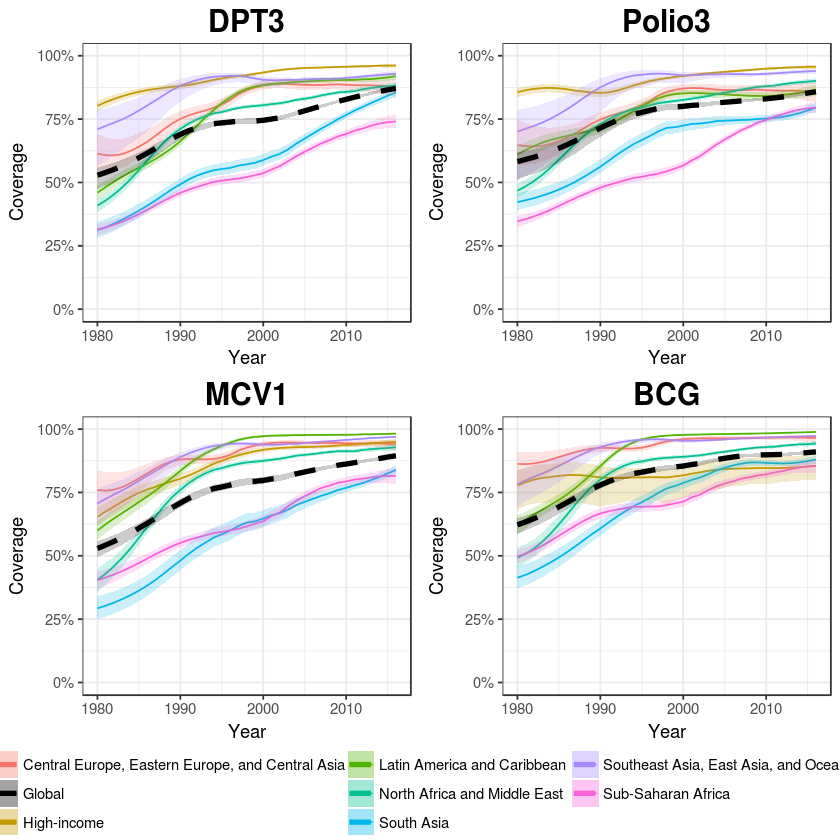

In [208]:
## Load summary
vaccs <- list.files(draws_root, "vacc")
df <- readRDS(paste0(temp_root, "/summary/coverage.rds"))

## Make time series graphs
df.graphs <- lapply(vaccs, function(x) {
    df.s <- df[me_name==x & level %in% c(0,1)]
    display <- me.db[me_name==x]$display_name
    return(plot.ts(df.s, by='location_name') + ggtitle(display))
})

names(df.graphs) <- vaccs
legend <- g_legend(df.graphs[[1]])
df.graphs <- lapply(df.graphs, function(x) x + theme(legend.position="none"))
    
p.main <- arrangeGrob(df.graphs$vacc_dpt3, df.graphs$vacc_polio3, df.graphs$vacc_mcv1, df.graphs$vacc_bcg, ncol=2)
fig.routine <- grid.arrange(p.main, legend, nrow=2, heights=c(8, 1))

## Save 
saveRDS(fig.routine, paste0(temp_root, "/figures/routine_ts.rds"))
    
p.main <- arrangeGrob(df.graphs$vacc_hepb3, df.graphs$vacc_hib3, df.graphs$vacc_pcv3, df.graphs$vacc_rotac, ncol=2)
fig.new <- grid.arrange(p.main, legend, nrow=2, heights=c(8, 1))
    
saveRDS(fig.new, paste0(temp_root, "/figures/new_ts.rds"))   
    


Number of countries that have introduced vaccinations over time

In [206]:
mes <- c("vacc_hepb3", "vacc_hib3", "vacc_pcv3", "vacc_rotac")
intro <- data.table(readRDS(paste0(data_root, "/exp/reference/vaccine_intro.rds")))
intro <- intro[!grepl("_", ihme_loc_id)]
intro <- intro[me_name %in% mes]
intro <- intro[, bin := ifelse(cv_intro_years == 0, 0, 1)]
intro <- intro[, bin_sum := sum(bin), by=c("year_id", "me_name")]
intro.s <- intro[, .(me_name, year_id, bin_sum)] %>% unique
intro.s <- intro.s[, pct := bin_sum/195]
intro.s <- merge(intro.s, me.db[, .(me_name, display_name)], by="me_name", all.x=TRUE)

fig.intro <- ggplot(intro.s) +
    geom_line(aes(x=year_id, y=pct, group=display_name, color=display_name)) +
    coord_cartesian(ylim=c(0, 1), xlim=c(1980, 2016)) + 
        xlab("Year") + ylab("Percent of countries introduced") + 
        scale_y_continuous(labels=scales::percent) +
        guides(color=guide_legend(ncol=4)) +
        theme_bw()+ 
        theme(axis.title=element_text(),
            plot.title=element_text(face="bold",size=18, hjust = 0.5),
            strip.text=element_text(size=12, face ="bold"),
            strip.background=element_blank(),
            axis.text.x = element_text(size = 9),
            panel.margin=unit(1,"lines"),
            legend.position = "bottom",
            legend.title = element_blank(),
            legend.background = element_blank(),
            legend.key = element_blank()
        )

saveRDS(fig.intro, paste0(temp_root, "/figures/intro_ts.rds"))



Maps of vaccine introduction

In [7]:
mes <- c("vacc_hepb3", "vacc_hib3", "vacc_pcv3", "vacc_rotac")
intro <- data.table(readRDS(paste0(data_root, "/exp/reference/vaccine_intro.rds")))
intro <- intro[!grepl("_", ihme_loc_id)]
intro <- intro[me_name %in% mes]
intro <- intro[, bin := ifelse(cv_intro_years == 0, 0, 1)]


Global full vacc coverage (4 routine) overlayed with global individual vacc coverage

In [219]:
df <- readRDS(paste0(temp_root, "/summary/coverage.rds"))
vaccs <- c("vacc_fullsub")
df.graphs <- lapply(vaccs, function(x) {
    df.s <- df[me_name==x & level %in% c(0,1)]
    display <- me.db[me_name==x]$display_name
    return(plot.ts(df.s, by='location_name'))
})

saveRDS(df.graphs[[1]], paste0(temp_root, "/figures/full_ts.rds"))

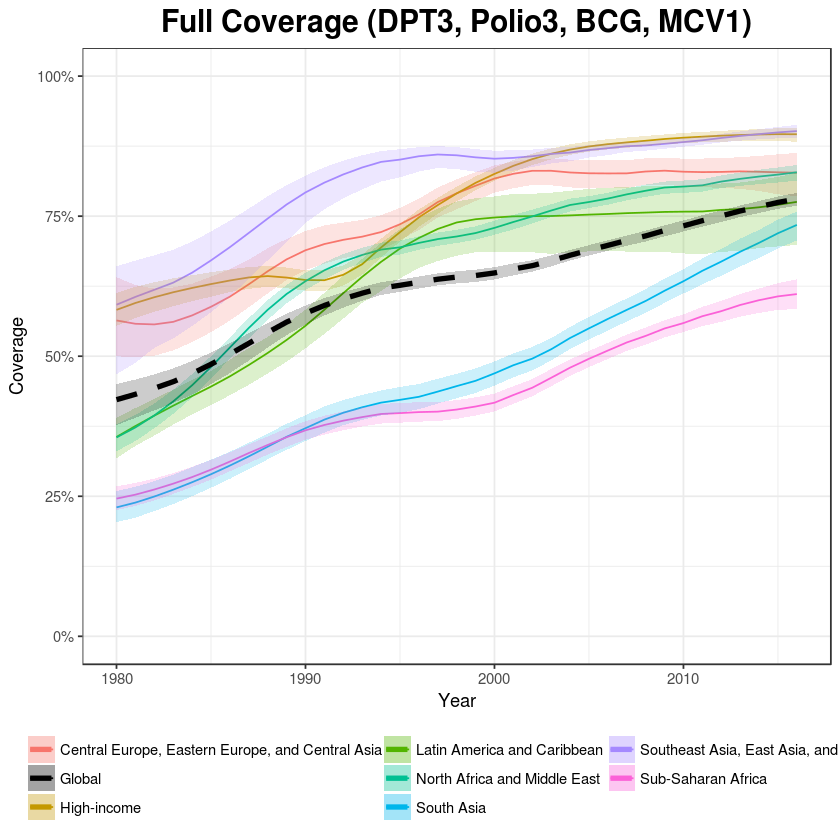

[[1]]

[[2]]

[[3]]


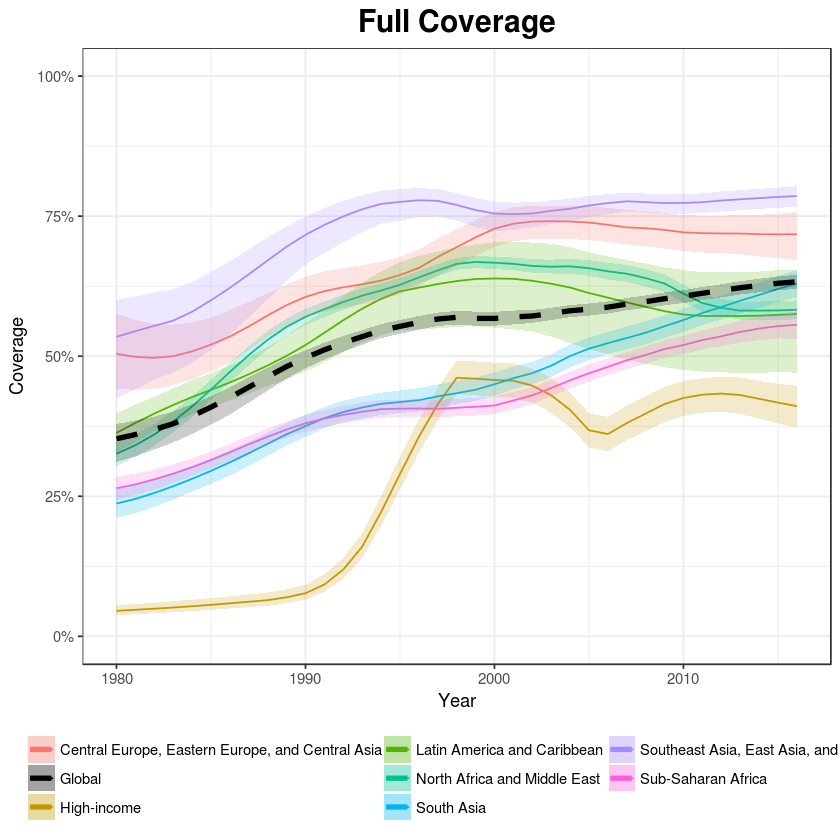

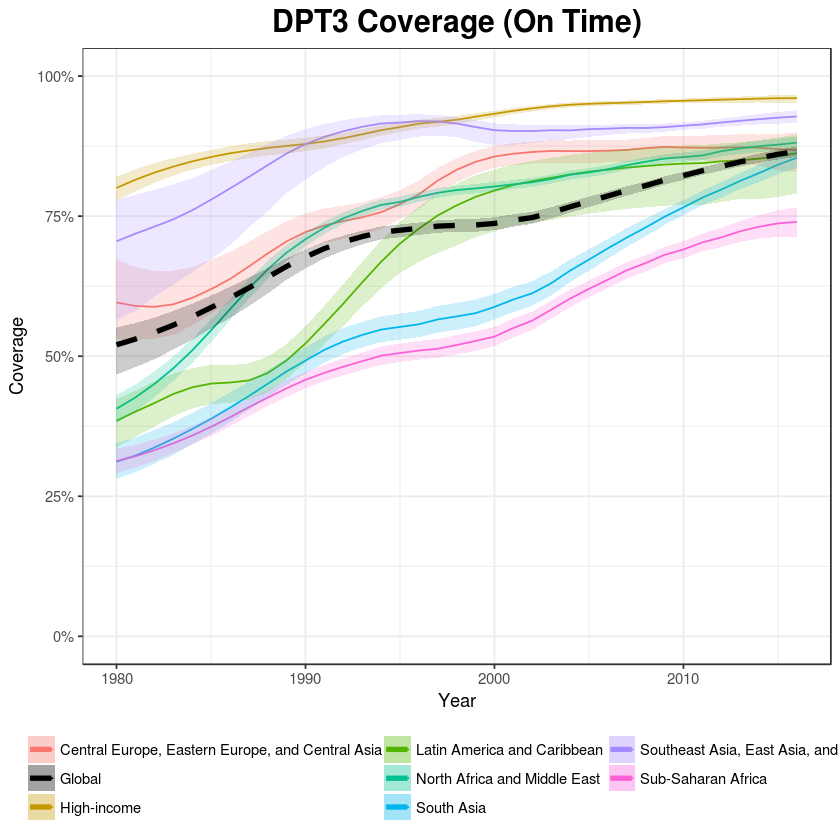

Time series graph of vaccination dropout over time (DPT1 overlayed with DPT3)

In [213]:
df <- readRDS(paste0(temp_root, '/summary/vacc_dpt1diff.rds'))
## Make time series graphs
df.graphs <- lapply("vacc_dpt1diff", function(x) {
    df.s <- df[me_name==x & level %in% c(0,1)]
    display <- me.db[me_name==x]$display_name
    return(plot.ts(df.s, by='location_name') + ggtitle("DPT1-DPT3 Drop-out Rate") + ylab("DPT1 - DPT3 Dropout") + coord_cartesian(ylim=c(0, 0.4), xlim=c(1980, 2016)))
})

saveRDS(df.graphs[[1]], paste0(temp_root, "/figures/dropout_ts.rds"))

Time series graph of DPT3 and timely DPT3 globally

In [218]:
df <- readRDS(paste0(temp_root, '/summary/vacc_dpt3time.rds'))
## Make time series graphs
df.graphs <- lapply("vacc_dpt3time", function(x) {
    df.s <- df[me_name==x & level %in% c(0,1)]
    display <- me.db[me_name==x]$display_name
    return(plot.ts(df.s, by='location_name') + ylab("Proportion of DPT3 (on time)")  )
})
saveRDS(df.graphs[[1]], paste0(temp_root, "/figures/timely_ts.rds"))

Regions defined for each Polygons
Regions defined for each Polygons


[1] " done."


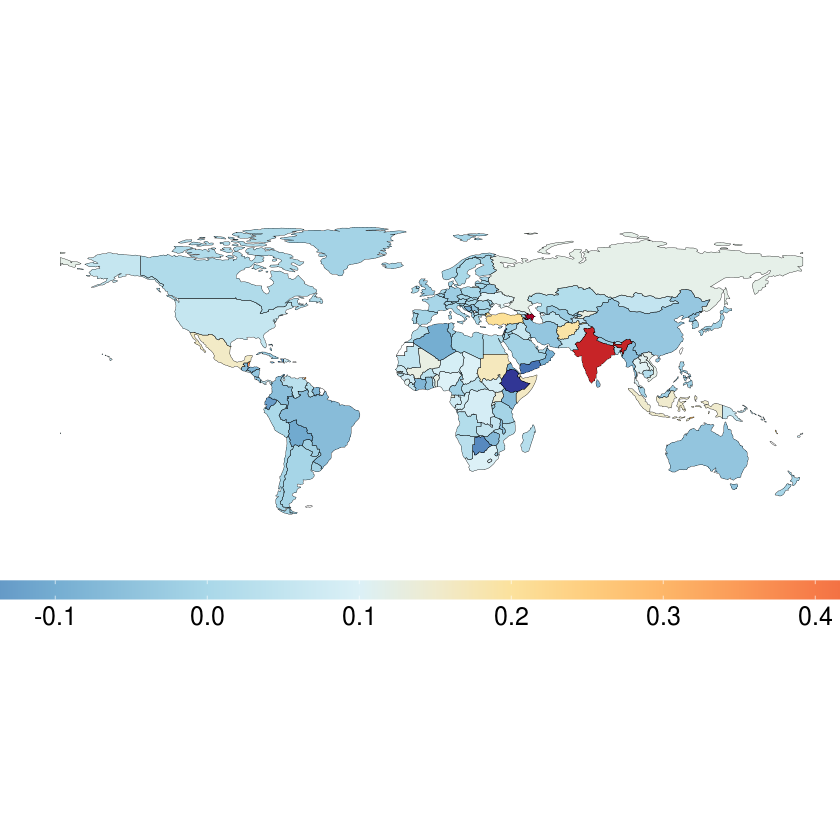

In [224]:
df <- readRDS(paste0(data_root, '/exp/to_model/vaccination.rds'))
df <- df[me_name=="vacc_dpt3"][, .(ihme_loc_id, cv_admin_bias)] %>% unique
df <- df[!is.na(cv_admin_bias)]
df$year_id <- 1980
df <- df[, cv_admin_bias := -cv_admin_bias]
graph <- make.map(df, 1980, 'cv_admin_bias', rev=TRUE, title="")
saveRDS(graph, paste0(temp_root, "/figures/adminbias_map.rds"))